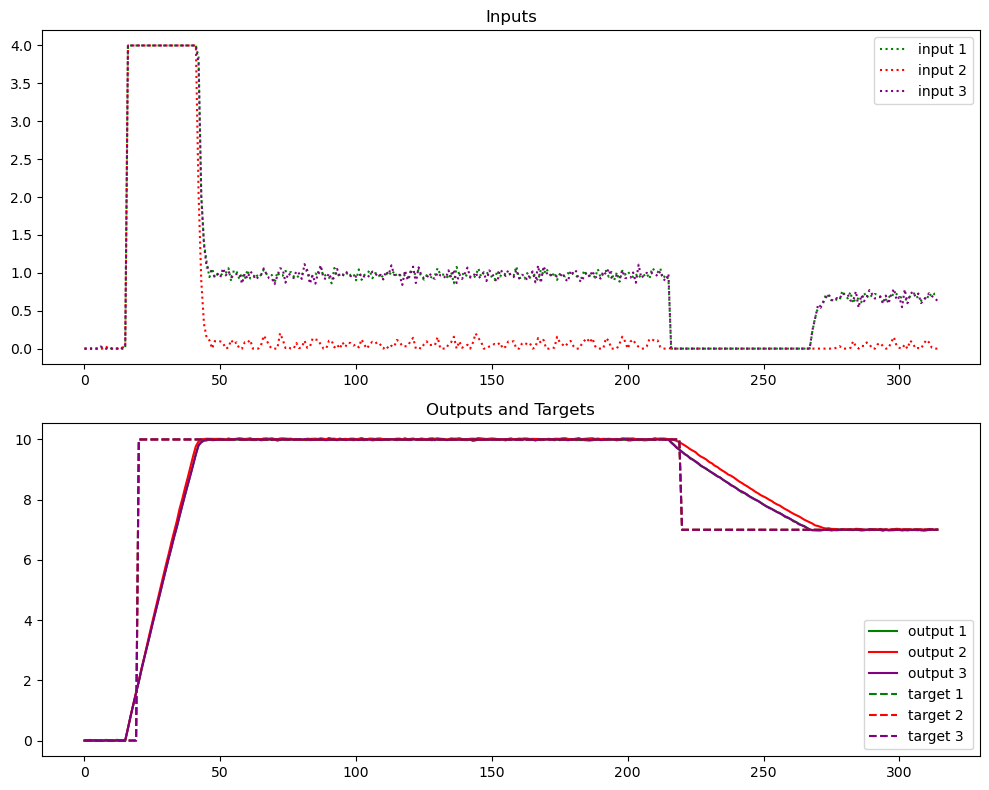

In [5]:

import numpy as np
import matplotlib.pyplot as plt
from deepc import Controller, RandomNoisyLTI

# Define a system
system = RandomNoisyLTI(
    A=[[0.88, 0.1, 0.01], 
       [0.1, 0.8, 0.1], 
       [0.01, 0.1, 0.88]],
    B=[[0.01, 0, 0], 
       [0, 0.01, 0], 
       [0, 0, 0.01]],
    C=[[10, 0, 0], 
       [0, 10, 0], 
       [0, 0, 10]],
    D=[[0, 0, 0], 
       [0, 0, 0], 
       [0, 0, 0]],
    x_ini=[1, 1, 1],
   noise_std=0.01
)

# Gather offline data
N = 21
# by defining a input sequence
u_d = [[0,0,0]] * N + [[0,0,10]] * N + [[0,10,0]] * N + [[10,0,0]] * N
# and applying it to the system
y_d = system.apply_multiple(u_d)

# Define how many steps the controller should look back
# to grasp the current state of the system
T_ini = 7

# Define how many steps the controller should look forward
r_len = 5

# Define the controller
constraint = lambda u: np.clip(u, 0, 4)
controller = Controller(u_d, y_d, T_ini, r_len, control_constrain_fkt=constraint)

# Reset the system
# to sepereate the offline data from the online data
system.set_state([0, 0, 0])  # This is intentionally not the same state as x_ini

# Warm up the controller
while not controller.is_initialized():
    u = [0, 0, 0]
    y = system.apply(u)
    controller.update(u, y)

# Simulate the system
u_online = []
y_online = []
r_online = [[0, 0, 0]] * 20 + [[1, 5, 10]] * 200 + [[7, 7, 7]] * 100
for i in range(len(r_online) - r_len):
    r = r_online[i: i + r_len]
    u = controller.apply(r)[0]
    y = system.apply(u)
    controller.update(u, y)
    u_online.append(u)
    y_online.append(y)
    r_online.append(r)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot inputs on the first subplot
ax1.plot([u[0] for u in u_online], label="input 1", color="green", linestyle=":")
ax1.plot([u[1] for u in u_online], label="input 2", color="red", linestyle=":")
ax1.plot([u[2] for u in u_online], label="input 3", color="purple", linestyle=":")
ax1.set_title('Inputs')
ax1.legend()

# Plot outputs and targets on the second subplot
ax2.plot([y[0] for y in y_online], label="output 1", color="green")
ax2.plot([y[1] for y in y_online], label="output 2", color="red")
ax2.plot([y[2] for y in y_online], label="output 3", color="purple")
ax2.plot([r[0] for r in r_online[:len(y_online)]], label="target 1", color="green", linestyle="--")
ax2.plot([r[1] for r in r_online[:len(y_online)]], label="target 2", color="red", linestyle="--")
ax2.plot([r[2] for r in r_online[:len(y_online)]], label="target 3", color="purple", linestyle="--")
ax2.set_title('Outputs and Targets')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
